# Metallicity Fit - NGC 628
Fit NGC 628 with the new BPASS + nebular models.

## Imports

In [1]:
import numpy as np
import h5py
rng = np.random.default_rng()
import astropy.units as u
from astropy.table import Table
from corner import corner
import matplotlib.pyplot as plt
plt.style.use('ebm-dejavu')
%matplotlib inline

from lightning import Lightning
from lightning.priors import UniformPrior, NormalPrior

## Setup

In [2]:
cat = Table.read('../photometry/ngc628_dale17_photometry.fits')

# Some annoyance with converting table columns to flat numpy arrays and text encoding:
# strings come in as bytestrings (unencoded) by default python wants UTF-8, I think.
# The labels are also padded with spaces.
filter_labels = np.array([s.decode().strip() for s in cat['FILTER_LABELS'].data[0]])
fnu_obs = cat['FNU_OBS'].data[0]
fnu_unc = cat['FNU_UNC'].data[0]
dl = cat['LUMIN_DIST'].data[0]

print('BPASS setup:')

agebins = [0.0] + list(np.logspace(7, np.log10(13.4e9), 7))

lgh = Lightning(filter_labels, 
                lum_dist=dl, 
                ages=agebins,
                nebula_lognH=3.5,
                stellar_type='BPASS-A24',
                SFH_type='Piecewise-Constant',
                atten_type='Modified-Calzetti',
                dust_emission=True,
                model_unc=0.10,
                print_setup_time=True)


lgh.flux_obs = fnu_obs * 1e3
lgh.flux_unc = fnu_unc * 1e3

# lgh_pg.save_json('ngc337_config.json')
# lgh_bp.save_json('ngc337_config_BPASS.json')

BPASS setup:
0.020 s elapsed in _get_filters
0.001 s elapsed in _get_wave_obs
2.076 s elapsed in stellar model setup
0.000 s elapsed in dust attenuation model setup
0.177 s elapsed in dust emission model setup
0.000 s elapsed in agn emission model setup
0.000 s elapsed in X-ray model setup
2.274 s elapsed total


In [3]:
lgh.print_params(verbose=True)


Piecewise-Constant
Parameter  Lo  Hi              Description
--------- --- --- ------------------------
    psi_1 0.0 inf SFR in stellar age bin 1
    psi_2 0.0 inf SFR in stellar age bin 2
    psi_3 0.0 inf SFR in stellar age bin 3
    psi_4 0.0 inf SFR in stellar age bin 4
    psi_5 0.0 inf SFR in stellar age bin 5
    psi_6 0.0 inf SFR in stellar age bin 6
    psi_7 0.0 inf SFR in stellar age bin 7

BPASS-Stellar-A24
Parameter                    Lo                 Hi                                                   Description
--------- --------------------- ------------------ -------------------------------------------------------------
     Zmet 0.0006471873203208087 0.0257649912911017 Metallicity (mass fraction, where solar = 0.020 ~ 10**[-1.7])
     logU                  -4.0               -1.5                             log10 of the ionization parameter

Modified-Calzetti
      Parameter   Lo  Hi                                              Description
--------------- ---- 

In [3]:
p0_seed = np.array([5,5,5,0,0,0,0,
                    0.014, -2.0,
                    0.1, -1.0, 0.0,
                    2, 3, 3e5, 0.01, 0.02])

priors = 7 * [UniformPrior([0,100])] + \
             [NormalPrior([0.013, 0.001]), NormalPrior([-2.5,0.75])] + \
             [UniformPrior([0,3]), UniformPrior([-1.5, 0.3]), None] + \
             [None, UniformPrior([0.1, 25]), None, UniformPrior([0,1]), UniformPrior([0.0047, 0.0458])]
const_dim = 7 * [False] + \
            [False, False] + \
            [False, False, True] + \
            [True, False, True, False, False]
const_dim = np.array(const_dim)
const_vals = p0_seed[const_dim]

Nwalkers = 64
p0 = p0_seed[None, :] + rng.normal(loc=0, scale=1e-5, size=(Nwalkers, len(p0_seed)))
p0[:, const_dim] = p0_seed[const_dim]

print('BPASS Model:')
mcmc = lgh.fit(p0,
               method='emcee',
               priors=priors,
               const_dim=const_dim,
               Nwalkers=Nwalkers,
               Nsteps=30000,
               progress=True)

# mcmc = l.fit(p0, method='emcee', Nwalkers=Nwalkers, Nsteps=20000, priors=priors, const_dim=const_dim)
# print(res_bp)

BPASS Model:


  0%|                                                                     | 0/30000 [00:00<?, ?it/s]/Users/eqm5663/miniconda3/envs/ciao-4.15/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|█████████████████████████████████████████████████████████| 30000/30000 [21:53<00:00, 22.84it/s]


In [4]:
print('MCMC mean acceptance fraction: %.3f' % (np.mean(mcmc.acceptance_fraction)))

MCMC mean acceptance fraction: 0.216


In [6]:
chain, logprob_chain, tau_ac = lgh.get_mcmc_chains(mcmc, discard=2000, thin=500, const_dim=const_dim, const_vals=p0_seed[const_dim])

         The autocorrelation estimate may be unreliable.


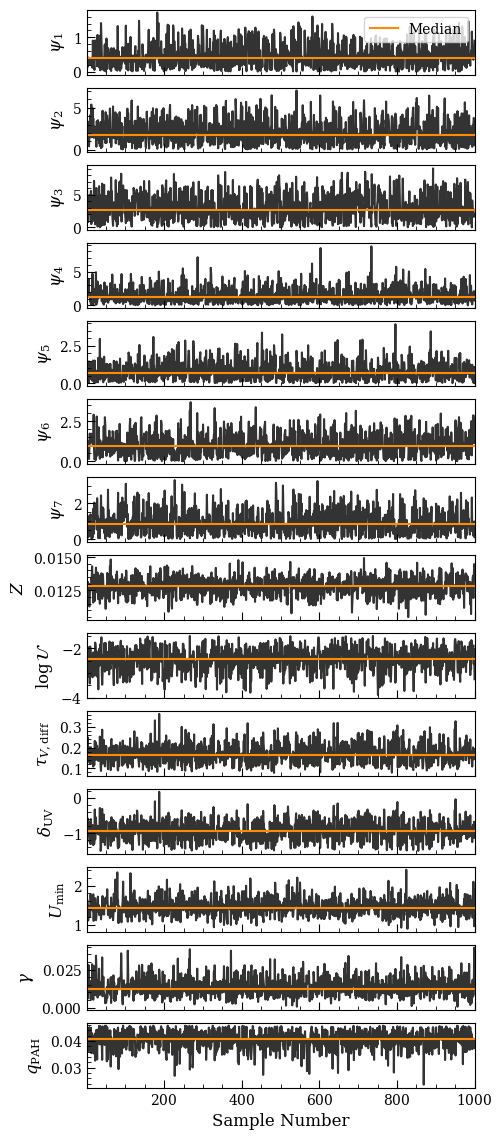

In [7]:
fig, axs = lgh.chain_plot(chain, color='k', alpha=0.8)

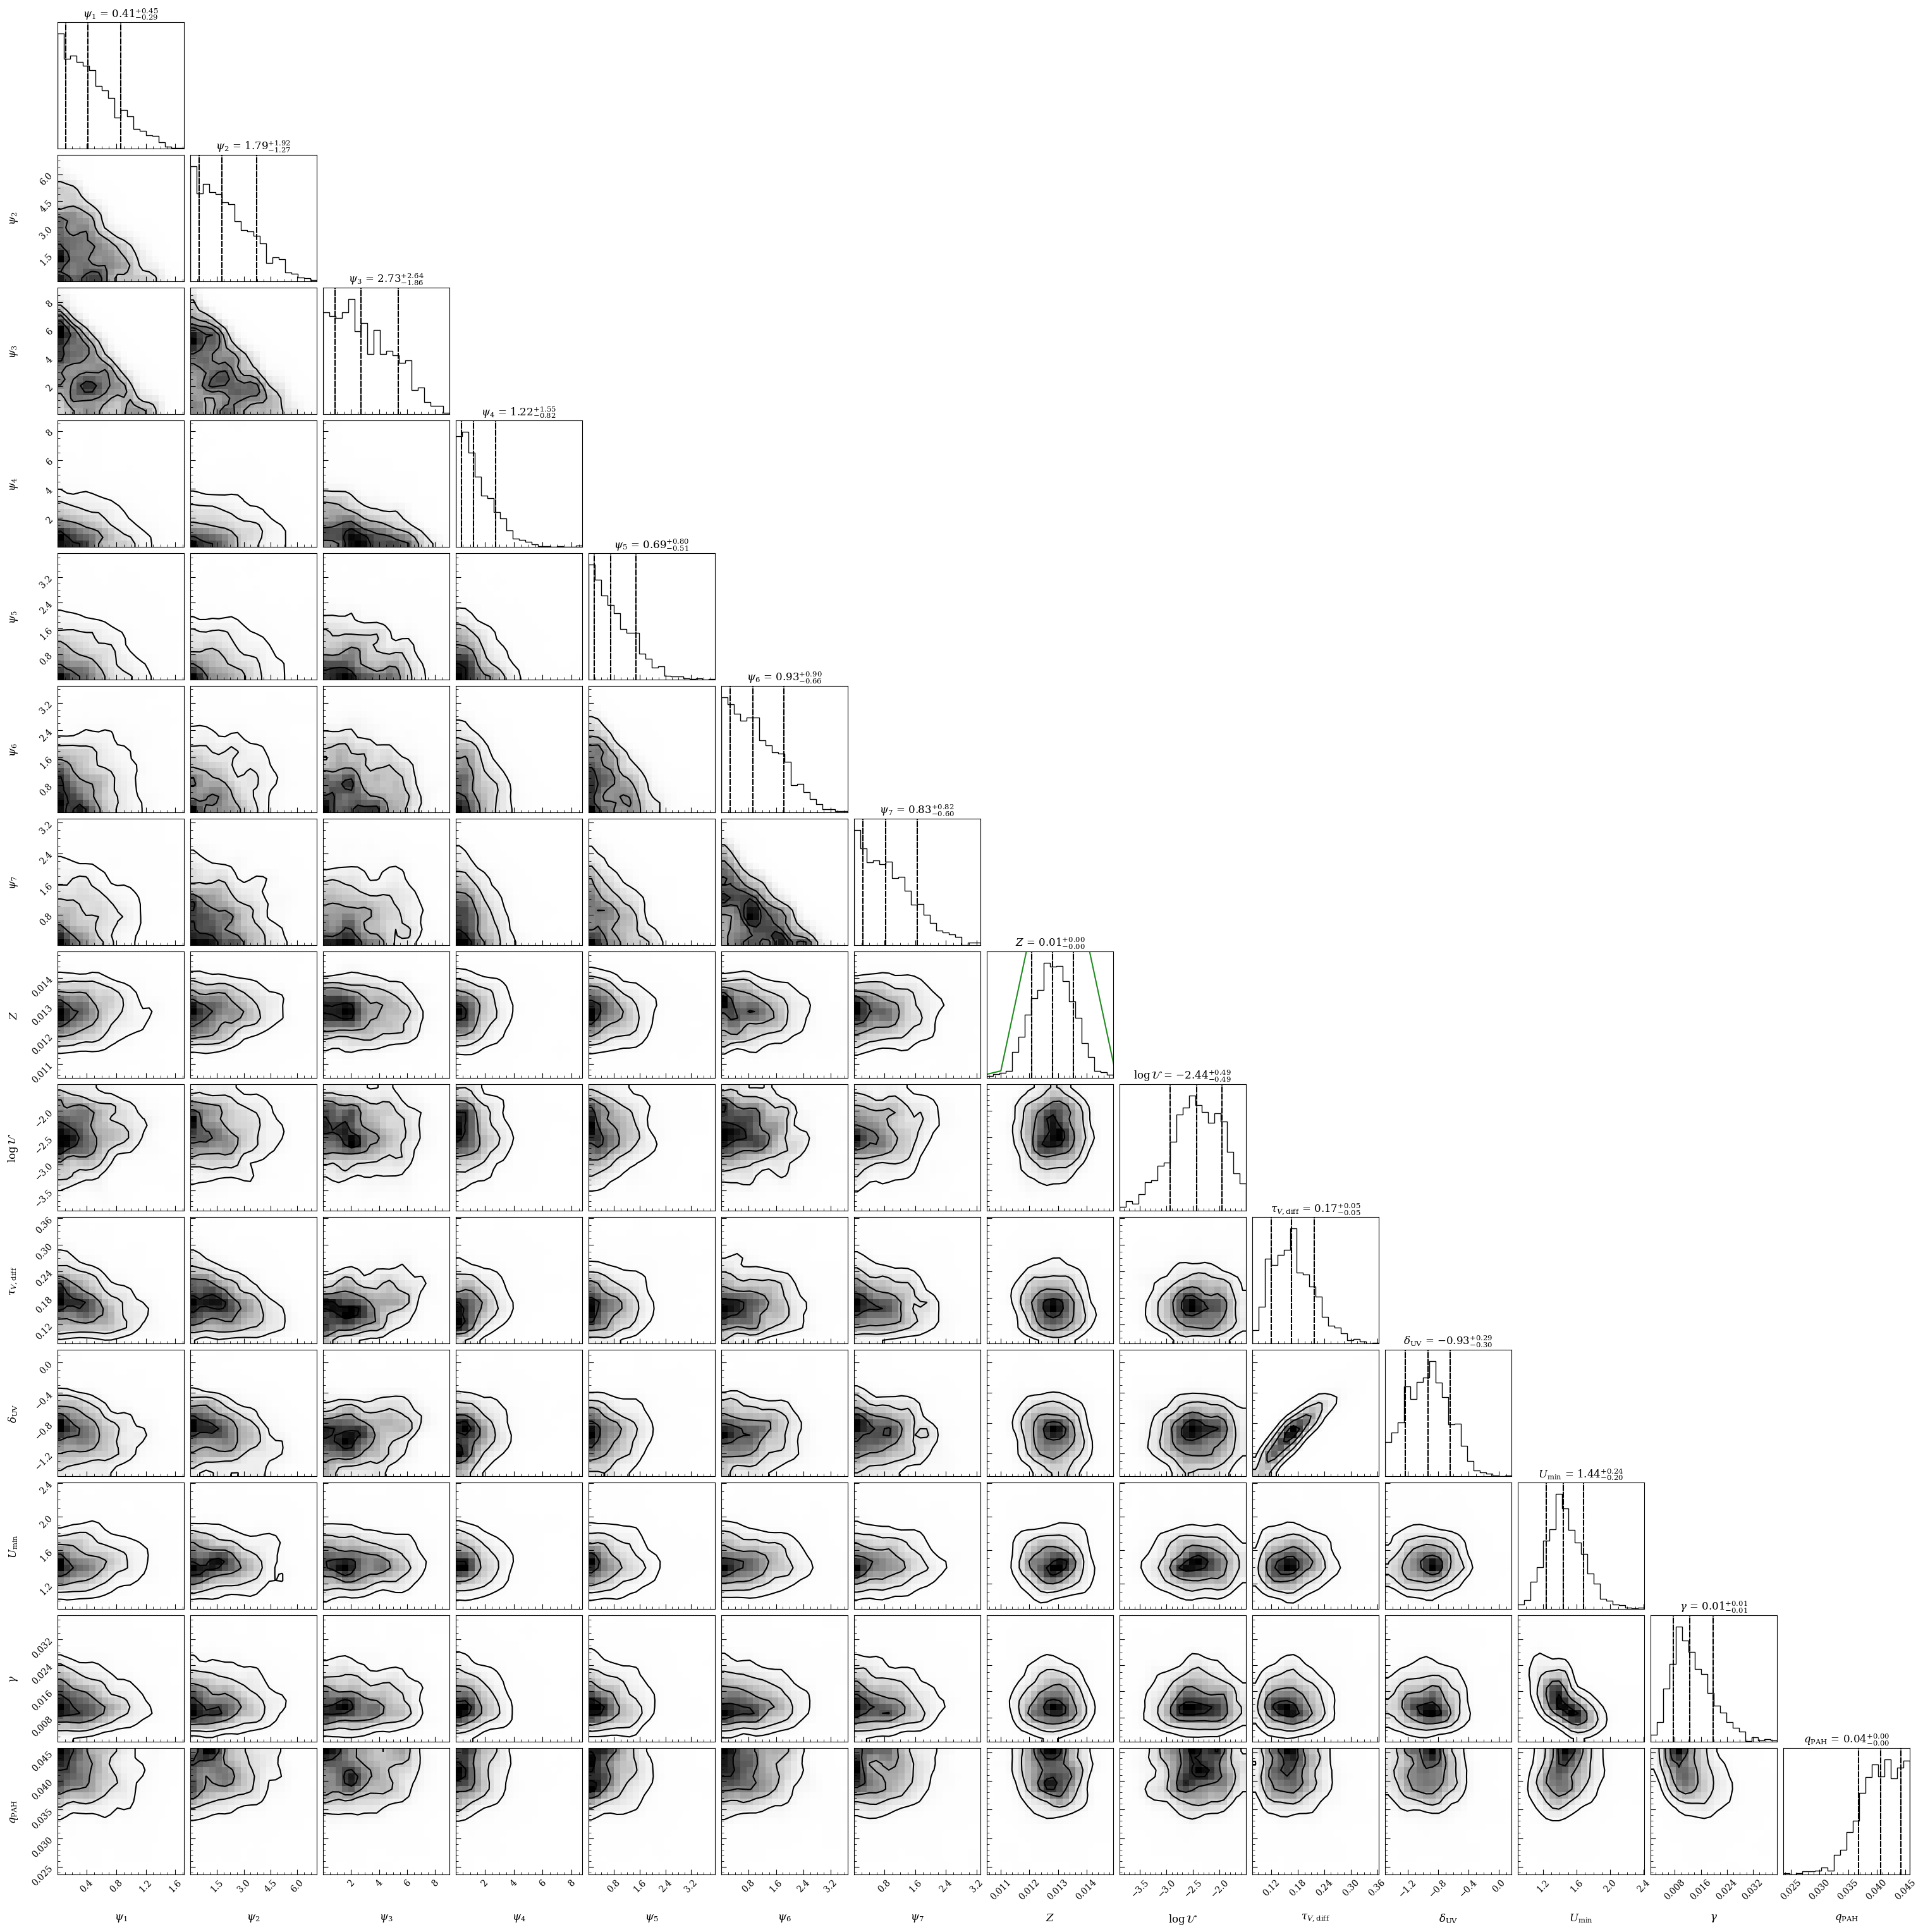

In [8]:
fig = lgh.corner_plot(chain, 
                      quantiles=(0.16, 0.50, 0.84),
                      smooth=1,
                      levels=None,
                      show_titles=True)

ZZ = np.linspace(0.001, 0.03, 30)
Zprior = lambda Z, mu, s: 1 / np.sqrt(2 * np.pi * s**2) * np.exp(-1 * (Z - mu)**2 / s**2)
axs = (np.array(fig.axes)).reshape(14,14)
yy = Zprior(ZZ, 0.013, 0.001)
axs[7,7].plot(ZZ, yy, color='forestgreen')

/Users/eqm5663/miniconda3/envs/ciao-4.15/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/Users/eqm5663/miniconda3/envs/ciao-4.15/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


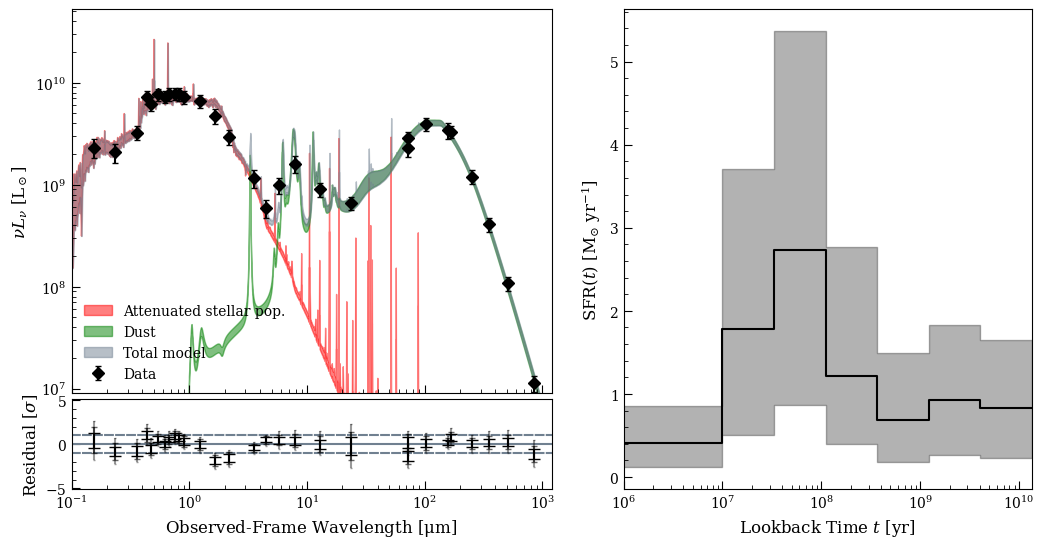

In [9]:
from lightning.plots import sed_plot_morebayesian, sed_plot_delchi_morebayesian, sfh_plot

fig5 = plt.figure(figsize=(12,6))
ax51 = fig5.add_axes([0.1, 0.26, 0.4, 0.64])
ax52 = fig5.add_axes([0.1, 0.1, 0.4, 0.15])
ax53 = fig5.add_axes([0.56, 0.1, 0.34, 0.8])

fig5, ax51 = sed_plot_morebayesian(lgh, chain, logprob_chain,
                                   plot_components=True,
                                   ax=ax51,
                                   legend_kwargs={'loc': 'lower left', 'frameon': False})
ax51.set_xticklabels([])
fig5, ax52 = sed_plot_delchi_morebayesian(lgh, chain, logprob_chain, ax=ax52)
fig5, ax53 = lgh.sfh_plot(chain, ax=ax53)

p = 0.033


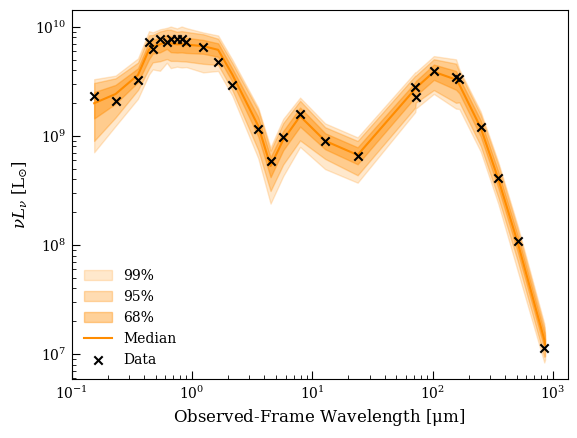

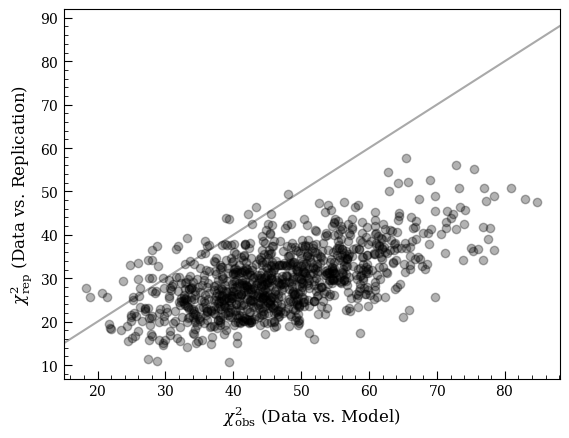

In [10]:
from lightning.ppc import ppc, ppc_sed

# I'm not thrilled about the way this works;
# the PPC needs all the parameters, even the constant
# ones. It's probably past time to make the MCMC fit function
# return a more user-friendly data structure that includes the
# constant values.
# param_arr = np.zeros((chain.shape[0], l.Nparams))
# param_arr[:, const_dim] = p[None, const_dim]
# param_arr[:, var_dim] = chain
 
pvalue, chi2_rep, chi2_obs = ppc(lgh, chain,
                                 logprob_chain,
                                 Nrep=1000,
                                 seed=12345)
fig, ax = ppc_sed(lgh, chain,
                  logprob_chain,
                  Nrep=1000,
                  seed=12345,
                  normalize=False)

fig2, ax2 = plt.subplots()

ax2.scatter(chi2_obs,
            chi2_rep,
            marker='o',
            alpha=0.3)

xlim = ax2.get_xlim()
ax2.plot(xlim, xlim, linestyle='-', color='darkgray', zorder=-1)
ax2.set_xlim(xlim)

ax2.set_xlabel(r'$\chi_{\rm obs}^2$ (Data vs. Model)')
ax2.set_ylabel(r'$\chi_{\rm rep}^2$ (Data vs. Replication)')


print('p = %.3f' % (pvalue))

## Line ratios


/var/folders/p6/qlk1ytxd09vf64nrq0vfw06wgg_lcz/T/ipykernel_28138/2039898712.py:9: RuntimeWarning: divide by zero encountered in log10
  OIIIHbeta_obs = np.log10(groves['OIII5006_FLUX_CORR'][mask] / groves['HB4861_FLUX_CORR'][mask])
/var/folders/p6/qlk1ytxd09vf64nrq0vfw06wgg_lcz/T/ipykernel_28138/2039898712.py:12: RuntimeWarning: divide by zero encountered in log10
  OIHalpha_obs = np.log10(groves['OI6300_FLUX_CORR'][mask] / groves['HA6562_FLUX_CORR'][mask])
/Users/eqm5663/Research/code/plightning/lightning/stellar/bpass.py:1281: RuntimeWarning: divide by zero encountered in log10
  np.log10(np.transpose(self.line_lum, axes=[1,2,0,3])),


Text(0.5, 0, '$\\rm \\log([O I] / H\\alpha)$')

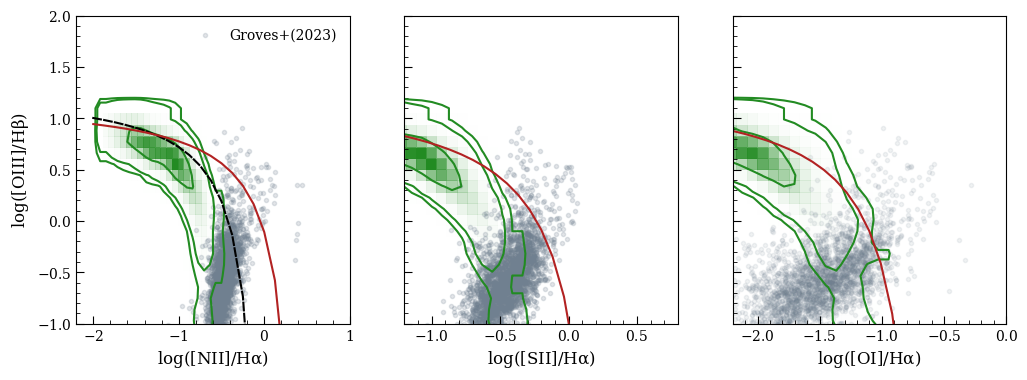

In [10]:
import corner
# Convenience functions I made to plot BPT-like diagnostic regions
from python_snippets import k06_NIIplot, k06_SIIplot, k06_OIplot

from astropy.table import Table
groves = Table.read('~/Research/010_PHANGS_Chandra/groves2023_nebula_catalog.fits')
mask = groves['gal_name'] == 'NGC0628'

OIIIHbeta_obs = np.log10(groves['OIII5006_FLUX_CORR'][mask] / groves['HB4861_FLUX_CORR'][mask])
NIIHalpha_obs = np.log10(groves['NII6583_FLUX_CORR'][mask] / groves['HA6562_FLUX_CORR'][mask])
SIIHalpha_obs = np.log10((groves['SII6716_FLUX_CORR'][mask] + groves['SII6730_FLUX_CORR'][mask]) / groves['HA6562_FLUX_CORR'][mask])
OIHalpha_obs = np.log10(groves['OI6300_FLUX_CORR'][mask] / groves['HA6562_FLUX_CORR'][mask])

linelum = lgh.stars.get_model_lines(lgh.sfh, chain[:,:7], chain[:,7:9])
# print(lineratios.shape)
# print(lineratios[0,:])

OIIImask = lgh.stars.line_names == b'O__3_500684A'
Halphamask = lgh.stars.line_names == b'H__1_656280A'
Hbetamask = lgh.stars.line_names == b'H__1_486132A'
NIImask = lgh.stars.line_names == b'N__2_658345A'
SII6717mask = lgh.stars.line_names == b'S__2_671644A'
SII6730mask = lgh.stars.line_names == b'S__2_673082A'
OImask = lgh.stars.line_names == b'BLND_630000A'

OIIIHbeta = np.log10(linelum[:,OIIImask] / linelum[:,Hbetamask])
NIIHalpha = np.log10(linelum[:,NIImask] / linelum[:,Halphamask])
SIIHalpha = np.log10((linelum[:,SII6717mask] + linelum[:,SII6730mask]) / linelum[:,Halphamask])
OIHalpha = np.log10(linelum[:,OImask] / linelum[:,Halphamask])

fig, axs = plt.subplots(1,3, figsize=(12,4))

# print(np.median(OIIIHbeta))
# print(np.median(NIIHalpha))
# print(np.median(SIIHalpha))
# print(np.median(OIHalpha))

corner.hist2d(NIIHalpha, OIIIHbeta, smooth=1, color='forestgreen', levels=[0.50, 0.95, 0.99], ax=axs[0])
k06_NIIplot(ax=axs[0])
axs[0].scatter(NIIHalpha_obs, OIIIHbeta_obs, marker='.', color='slategray', alpha=0.2, label='Groves+(2023)')

# OIIIHbeta_M06 = np.log10(275 / 152.700)
# NIIHalpha_M06 = np.log10(4.7 / 455.00)
# axs[0].scatter(NIIHalpha_M06, OIIIHbeta_M06, marker='*', s=100, color='forestgreen', label='Moustakas+(2006)')

axs[0].set_xlim(-2.2,1)
axs[0].set_ylim(-1,2)
axs[0].set_xlabel(r'$\rm \log([N II] / H\alpha)$')
axs[0].set_ylabel(r'$\rm \log([O III] / H\beta)$')
axs[0].legend(loc='best')

corner.hist2d(SIIHalpha, OIIIHbeta, smooth=1, color='forestgreen', levels=[0.50, 0.95, 0.99], ax=axs[1])
axs[1].scatter(SIIHalpha_obs, OIIIHbeta_obs, marker='.', color='slategray', alpha=0.2)
k06_SIIplot(ax=axs[1])
axs[1].set_xlim(-1.2,0.8)
axs[1].set_ylim(-1,2)
axs[1].set_yticklabels([])
axs[1].set_xlabel(r'$\rm \log([S II] / H\alpha)$')

corner.hist2d(OIHalpha, OIIIHbeta, smooth=1, color='forestgreen', levels=[0.50, 0.95, 0.99], ax=axs[2])
axs[2].scatter(OIHalpha_obs, OIIIHbeta_obs, marker='.', color='slategray', alpha=0.1)
k06_OIplot(ax=axs[2])
axs[2].set_xlim(-2.2,0.0)
axs[2].set_ylim(-1,2)
axs[2].set_yticklabels([])
axs[2].set_xlabel(r'$\rm \log([O I] / H\alpha)$')

## Try the older BPASS+Cloudy models
To compare the line ratios especially.

In [31]:
cat = Table.read('../photometry/ngc628_dale17_photometry.fits')

# Some annoyance with converting table columns to flat numpy arrays and text encoding:
# strings come in as bytestrings (unencoded) by default python wants UTF-8, I think.
# The labels are also padded with spaces.
filter_labels = np.array([s.decode().strip() for s in cat['FILTER_LABELS'].data[0]])
fnu_obs = cat['FNU_OBS'].data[0]
fnu_unc = cat['FNU_UNC'].data[0]
dl = cat['LUMIN_DIST'].data[0]

print('BPASS setup:')

agebins = [0.0] + list(np.logspace(7, np.log10(13.4e9), 7))

lgh = Lightning(filter_labels, 
                lum_dist=dl, 
                ages=agebins,
                stellar_type='BPASS',
                SFH_type='Piecewise-Constant',
                atten_type='Modified-Calzetti',
                dust_emission=True,
                model_unc=0.10,
                print_setup_time=True)


lgh.flux_obs = fnu_obs * 1e3
lgh.flux_unc = fnu_unc * 1e3

# lgh_pg.save_json('ngc337_config.json')
# lgh_bp.save_json('ngc337_config_BPASS.json')

BPASS setup:
0.028 s elapsed in _get_filters
0.001 s elapsed in _get_wave_obs
2.792 s elapsed in stellar model setup
0.000 s elapsed in dust attenuation model setup
0.226 s elapsed in dust emission model setup
0.000 s elapsed in agn emission model setup
0.000 s elapsed in X-ray model setup
3.047 s elapsed total


In [49]:
p0_seed = np.array([5,5,5,0,0,0,0,
                    0.014, -2.0,
                    0.1, -1.0, 0.0,
                    2, 3, 3e5, 0.01, 0.02])

priors = 7 * [UniformPrior([0,100])] + \
             [NormalPrior([0.013, 0.003]), NormalPrior([-3.0,0.75])] + \
             [UniformPrior([0,3]), UniformPrior([-1.5, 0.3]), None] + \
             [None, UniformPrior([0.1, 25]), None, UniformPrior([0,1]), UniformPrior([0.0047, 0.0458])]
const_dim = 7 * [False] + \
            [False, False] + \
            [False, False, True] + \
            [True, False, True, False, False]
const_dim = np.array(const_dim)
const_vals = p0_seed[const_dim]

Nwalkers = 64
p0 = p0_seed[None, :] + rng.normal(loc=0, scale=1e-5, size=(Nwalkers, len(p0_seed)))
p0[:, const_dim] = p0_seed[const_dim]

print('BPASS Model:')
mcmc = lgh.fit(p0,
               method='emcee',
               priors=priors,
               const_dim=const_dim,
               Nwalkers=Nwalkers,
               Nsteps=30000,
               progress=True)

# mcmc = l.fit(p0, method='emcee', Nwalkers=Nwalkers, Nsteps=20000, priors=priors, const_dim=const_dim)
# print(res_bp)

/Users/eqm5663/Research/code/plightning/lightning/stellar/bpass.py:473: RuntimeWarning: divide by zero encountered in log10
  np.log10(np.transpose(self.Lnu_obs, axes=[1,2,0,3])),


BPASS Model:


  0%|                                                                                                                                                            | 0/30000 [00:00<?, ?it/s]/Users/eqm5663/miniconda3/envs/ciao-4.15/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30000/30000 [15:59<00:00, 31.27it/s]


In [50]:
print('MCMC mean acceptance fraction: %.3f' % (np.mean(mcmc.acceptance_fraction)))

MCMC mean acceptance fraction: 0.220


In [52]:
chain, logprob_chain, tau_ac = lgh.get_mcmc_chains(mcmc, discard=2000, thin=500, const_dim=const_dim, const_vals=p0_seed[const_dim])

         The autocorrelation estimate may be unreliable.


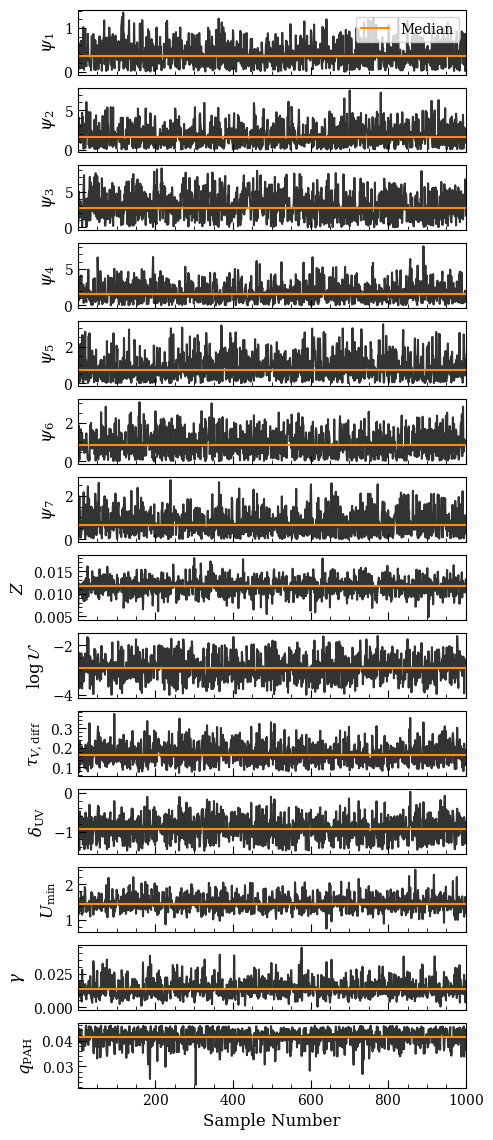

In [53]:
fig, axs = lgh.chain_plot(chain, color='k', alpha=0.8)

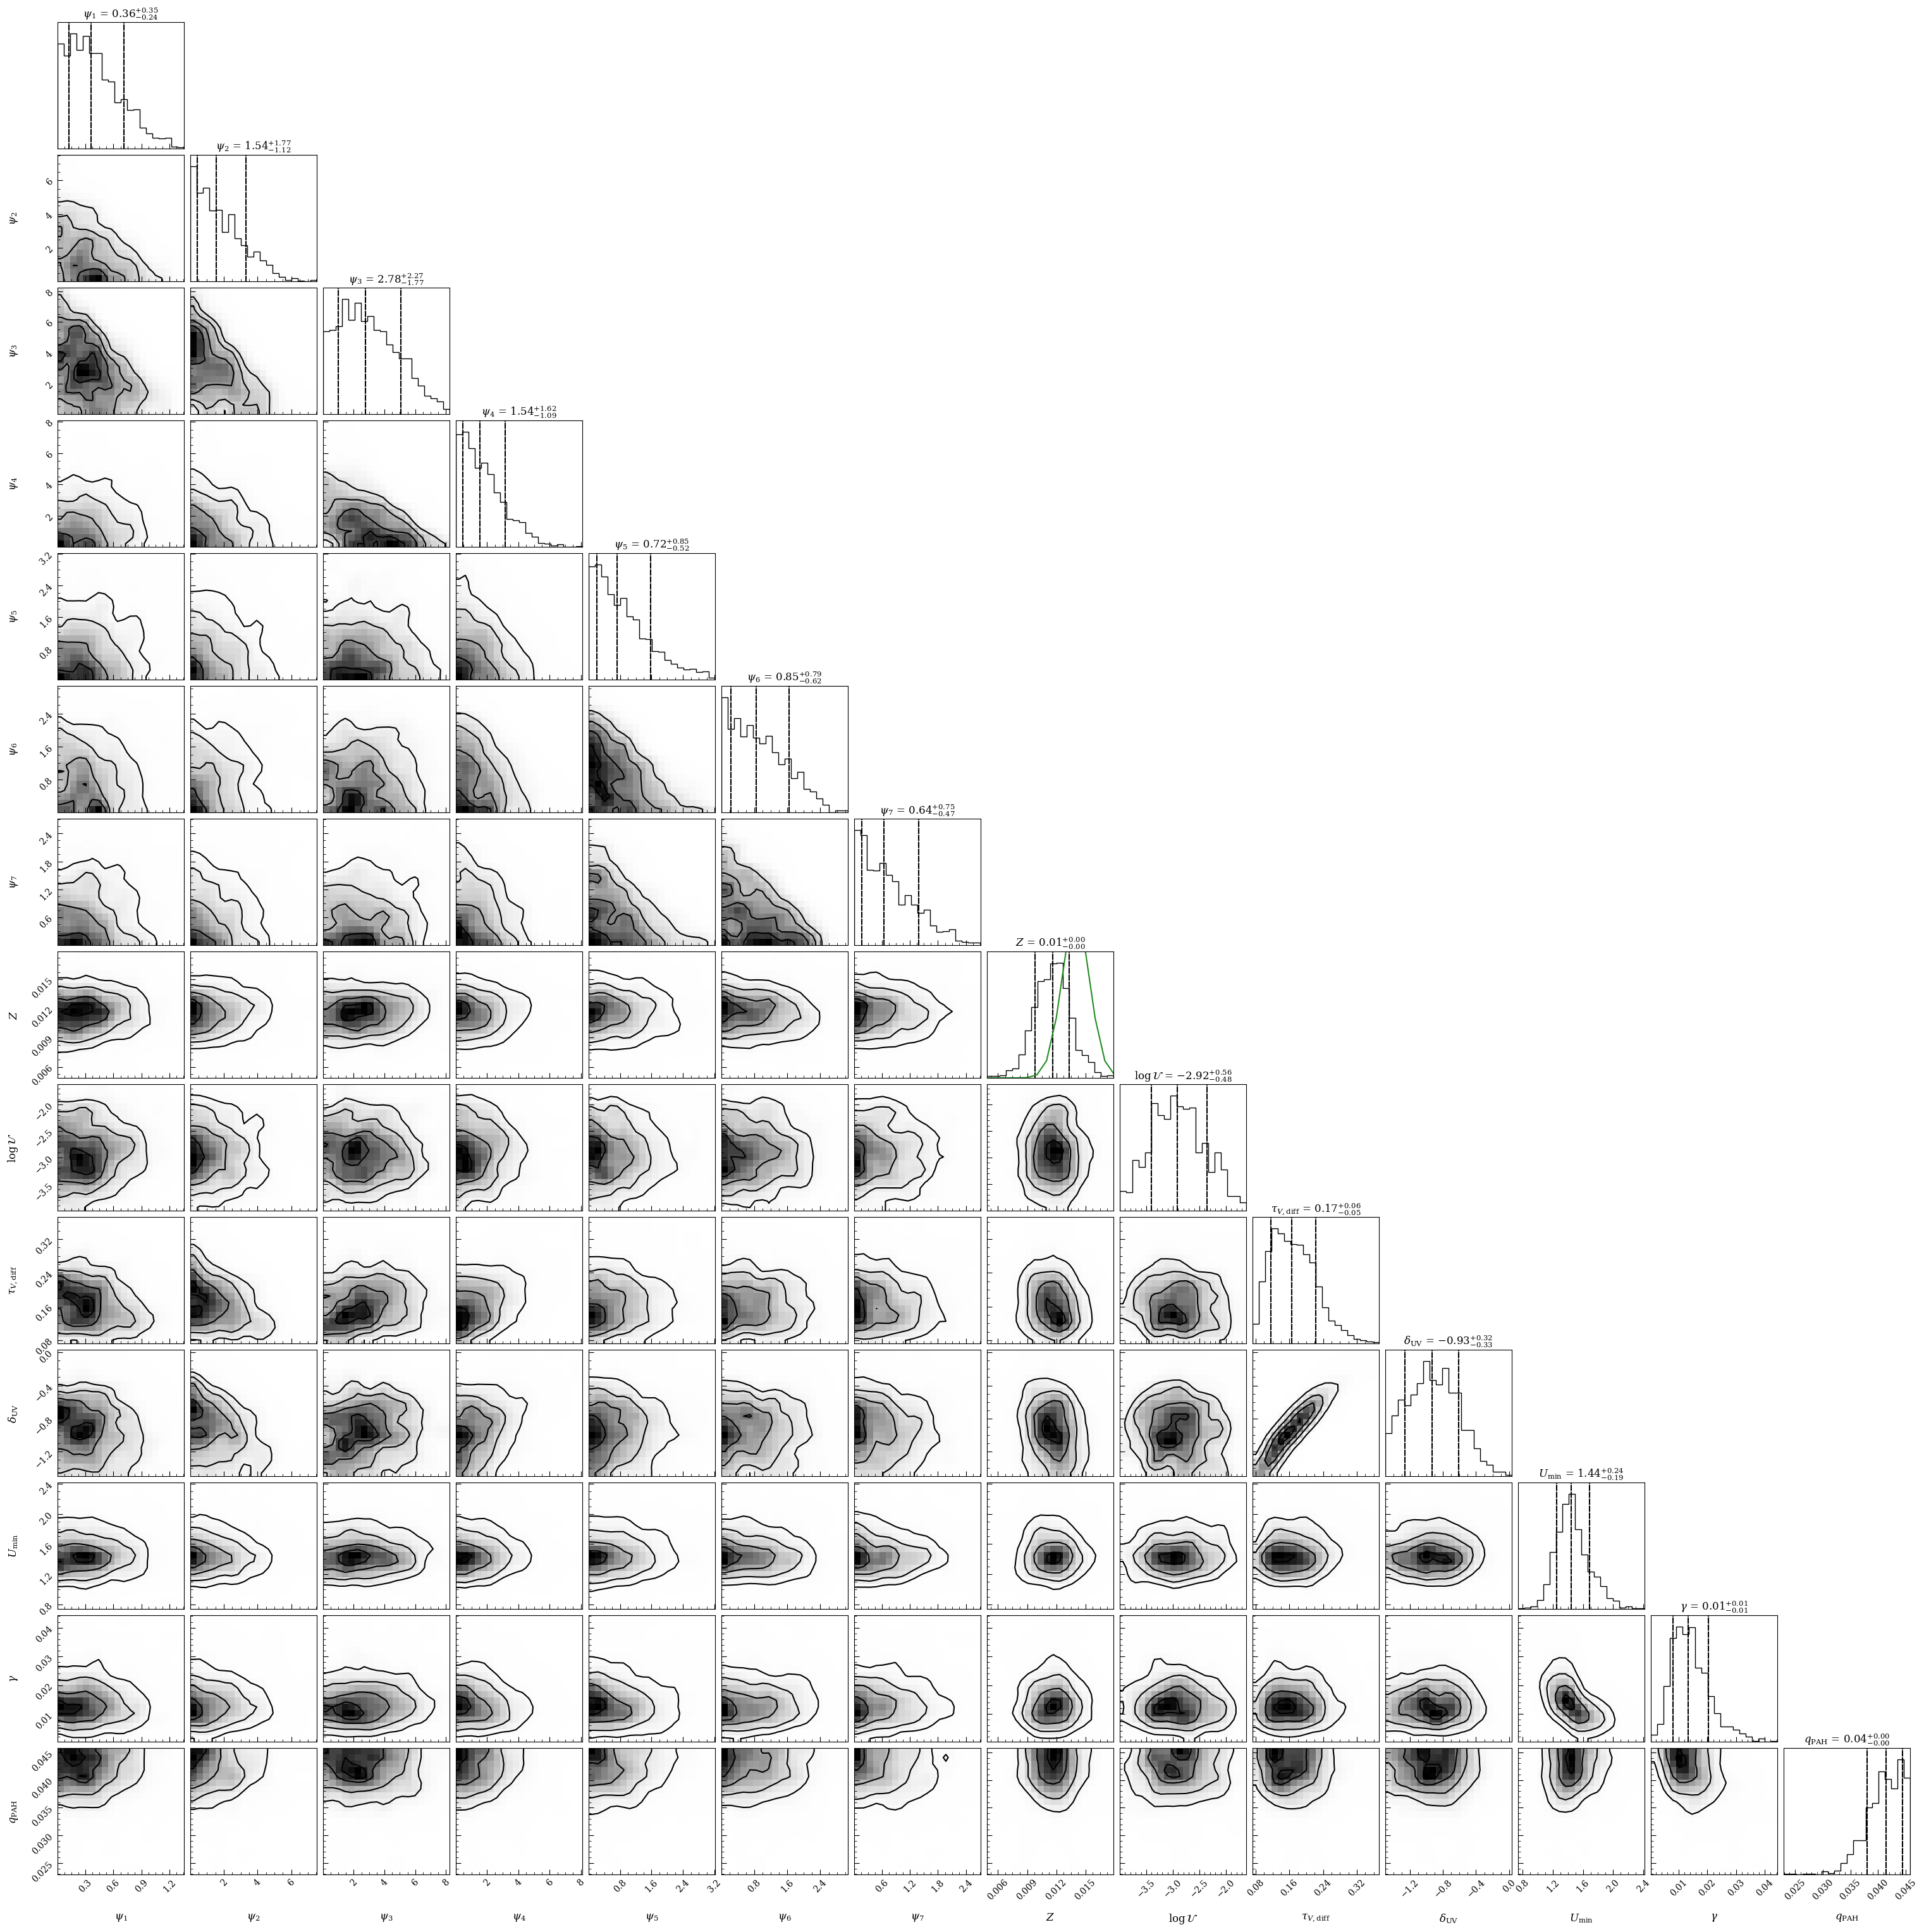

In [54]:
fig = lgh.corner_plot(chain, 
                      quantiles=(0.16, 0.50, 0.84),
                      smooth=1,
                      levels=None,
                      show_titles=True)

ZZ = np.linspace(0.001, 0.03, 30)
Zprior = lambda Z, mu, s: 1 / np.sqrt(2 * np.pi * s**2) * np.exp(-1 * (Z - mu)**2 / s**2)
axs = (np.array(fig.axes)).reshape(14,14)
yy = Zprior(ZZ, 0.014, 0.002)
axs[7,7].plot(ZZ, yy, color='forestgreen')

/Users/eqm5663/Research/code/plightning/lightning/stellar/bpass.py:473: RuntimeWarning: divide by zero encountered in log10
  np.log10(np.transpose(self.Lnu_obs, axes=[1,2,0,3])),
/Users/eqm5663/Research/code/plightning/lightning/stellar/bpass.py:473: RuntimeWarning: divide by zero encountered in log10
  np.log10(np.transpose(self.Lnu_obs, axes=[1,2,0,3])),
/Users/eqm5663/miniconda3/envs/ciao-4.15/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/Users/eqm5663/miniconda3/envs/ciao-4.15/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


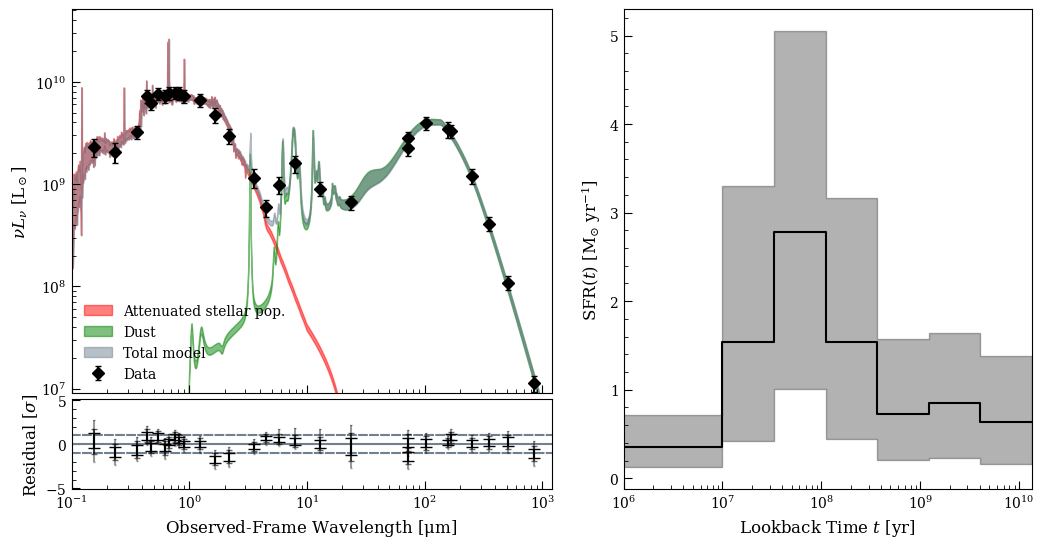

In [55]:
from lightning.plots import sed_plot_morebayesian, sed_plot_delchi_morebayesian, sfh_plot

fig5 = plt.figure(figsize=(12,6))
ax51 = fig5.add_axes([0.1, 0.26, 0.4, 0.64])
ax52 = fig5.add_axes([0.1, 0.1, 0.4, 0.15])
ax53 = fig5.add_axes([0.56, 0.1, 0.34, 0.8])

fig5, ax51 = sed_plot_morebayesian(lgh, chain, logprob_chain,
                                   plot_components=True,
                                   ax=ax51,
                                   legend_kwargs={'loc': 'lower left', 'frameon': False})
ax51.set_xticklabels([])
fig5, ax52 = sed_plot_delchi_morebayesian(lgh, chain, logprob_chain, ax=ax52)
fig5, ax53 = lgh.sfh_plot(chain, ax=ax53)

In [38]:
print(lgh.stars.line_names)

[b'Ly_A' b'CIII1548' b'HeII1640' b'OIII1666' b'CIII1909' b'OII3726'
 b'OII3729' b'HeII4685' b'Hbeta' b'OIII5007' b'Halpha' b'NII6584'
 b'SII6716' b'SII6730' b'SIII9068' b'SIII9530' b'HeI1.083']


0.55588670945865
-5.188020367183089
-0.5791833642589199


/var/folders/p6/qlk1ytxd09vf64nrq0vfw06wgg_lcz/T/ipykernel_2096/4006764960.py:9: RuntimeWarning: divide by zero encountered in log10
  OIIIHbeta_obs = np.log10(groves['OIII5006_FLUX_CORR'][mask] / groves['HB4861_FLUX_CORR'][mask])
/var/folders/p6/qlk1ytxd09vf64nrq0vfw06wgg_lcz/T/ipykernel_2096/4006764960.py:12: RuntimeWarning: divide by zero encountered in log10
  OIHalpha_obs = np.log10(groves['OI6300_FLUX_CORR'][mask] / groves['HA6562_FLUX_CORR'][mask])
/Users/eqm5663/Research/code/plightning/lightning/stellar/bpass.py:665: RuntimeWarning: divide by zero encountered in log10
  np.log10(np.transpose(self.line_lum, axes=[1,2,0,3])),


Text(0.5, 0, '$\\rm \\log([O I] / H\\alpha)$')

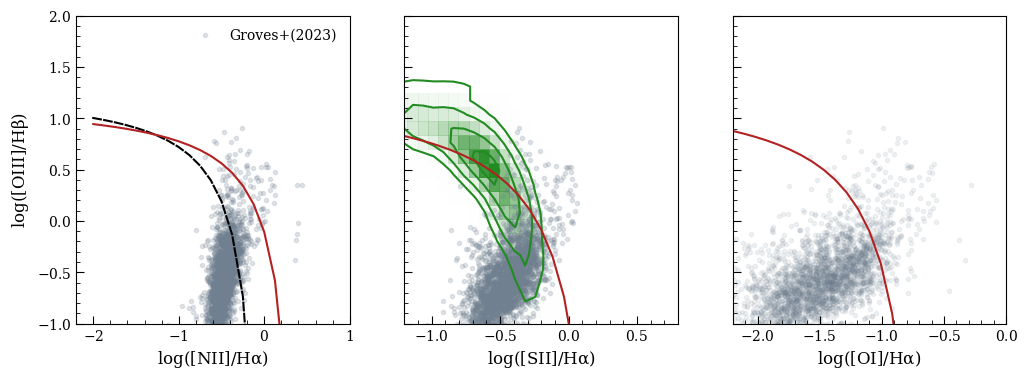

In [56]:
import corner
# Convenience functions I made to plot BPT-like diagnostic regions
from python_snippets import k06_NIIplot, k06_SIIplot, k06_OIplot

from astropy.table import Table
groves = Table.read('~/Research/010_PHANGS_Chandra/groves2023_nebula_catalog.fits')
mask = groves['gal_name'] == 'NGC0628'

OIIIHbeta_obs = np.log10(groves['OIII5006_FLUX_CORR'][mask] / groves['HB4861_FLUX_CORR'][mask])
NIIHalpha_obs = np.log10(groves['NII6583_FLUX_CORR'][mask] / groves['HA6562_FLUX_CORR'][mask])
SIIHalpha_obs = np.log10((groves['SII6716_FLUX_CORR'][mask] + groves['SII6730_FLUX_CORR'][mask]) / groves['HA6562_FLUX_CORR'][mask])
OIHalpha_obs = np.log10(groves['OI6300_FLUX_CORR'][mask] / groves['HA6562_FLUX_CORR'][mask])

lineratios = lgh.stars.get_model_lines(lgh.sfh, chain[:,:7], chain[:,7:9])
# print(lineratios.shape)
# print(lineratios[0,:])

OIIImask = lgh.stars.line_names == b'OIII5007'
Halphamask = lgh.stars.line_names == b'Halpha'
Hbetamask = lgh.stars.line_names == b'Hbeta'
NIImask = lgh.stars.line_names == b'NII6584'
SII6717mask = lgh.stars.line_names == b'SII6716'
SII6730mask = lgh.stars.line_names == b'SII6730'
# OImask = lgh.stars.line_names == b'BLND_630000A'

OIIIHbeta = np.log10(lineratios[:,OIIImask] / lineratios[:,Hbetamask])
NIIHalpha = np.log10(lineratios[:,NIImask] / lineratios[:,Halphamask])
SIIHalpha = np.log10((lineratios[:,SII6717mask] + lineratios[:,SII6730mask]) / lineratios[:,Halphamask])
# OIHalpha = np.log10(lineratios[:,OImask] / lineratios[:,Halphamask])

fig, axs = plt.subplots(1,3, figsize=(12,4))

print(np.median(OIIIHbeta))
print(np.median(NIIHalpha))
print(np.median(SIIHalpha))
# print(np.median(OIHalpha))

corner.hist2d(NIIHalpha, OIIIHbeta, smooth=1, color='forestgreen', ax=axs[0])
k06_NIIplot(ax=axs[0])
axs[0].scatter(NIIHalpha_obs, OIIIHbeta_obs, marker='.', color='slategray', alpha=0.2, label='Groves+(2023)')

# OIIIHbeta_M06 = np.log10(275 / 152.700)
# NIIHalpha_M06 = np.log10(4.7 / 455.00)
# axs[0].scatter(NIIHalpha_M06, OIIIHbeta_M06, marker='*', s=100, color='forestgreen', label='Moustakas+(2006)')

axs[0].set_xlim(-2.2,1)
axs[0].set_ylim(-1,2)
axs[0].set_xlabel(r'$\rm \log([N II] / H\alpha)$')
axs[0].set_ylabel(r'$\rm \log([O III] / H\beta)$')
axs[0].legend(loc='best')

corner.hist2d(SIIHalpha, OIIIHbeta, smooth=1, color='forestgreen', ax=axs[1])
axs[1].scatter(SIIHalpha_obs, OIIIHbeta_obs, marker='.', color='slategray', alpha=0.2)
k06_SIIplot(ax=axs[1])
axs[1].set_xlim(-1.2,0.8)
axs[1].set_ylim(-1,2)
axs[1].set_yticklabels([])
axs[1].set_xlabel(r'$\rm \log([S II] / H\alpha)$')

# corner.hist2d(OIHalpha, OIIIHbeta, smooth=1, color='forestgreen', ax=axs[2])
axs[2].scatter(OIHalpha_obs, OIIIHbeta_obs, marker='.', color='slategray', alpha=0.1)
k06_OIplot(ax=axs[2])
axs[2].set_xlim(-2.2,0.0)
axs[2].set_ylim(-1,2)
axs[2].set_yticklabels([])
axs[2].set_xlabel(r'$\rm \log([O I] / H\alpha)$')